In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cluster import AffinityPropagation, DBSCAN, SpectralClustering, KMeans
from tqdm import tqdm
import requests
from io import StringIO
import io

In [103]:
file_url = "https://raw.githubusercontent.com/Tallivm/vu-python/main/hw4_2025.csv"
response = requests.get(file_url)
csv_data = StringIO(response.text)

TO_PREDICT = 'snail_genus'

In [104]:
raw = pd.read_csv(csv_data, index_col=0)

def print_data_report(df, title="Data Report"):
    print(f"\n{'='*60}")
    print(f"{title}")
    print(f"{'='*60}\n")
    
    total_nans = df.isna().sum().sum()
    print(f"Total NaN values: {total_nans}")
    if total_nans > 0:
        print("\nNaN values by column:")
        nan_cols = df.isna().sum()
        nan_cols = nan_cols[nan_cols > 0]
        for col, count in nan_cols.items():
            print(f"  - {col}: {count}")
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\nNumeric columns statistics:")
        for col in numeric_cols:
            print(f"  - {col}:")
            print(f"    Min: {df[col].min():.4f}, Mean: {df[col].mean():.4f}, Max: {df[col].max():.4f}")
    
    cat_cols = df.select_dtypes(include=['object']).columns
    if len(cat_cols) > 0:
        print(f"\nCategorical columns:")
        for col in cat_cols:
            print(f"  - {col}: {df[col].nunique()} unique values")
            value_counts = df[col].value_counts()
            for val, count in value_counts.items():
                print(f"    {val}: {count}")
    
    print(f"\n{'='*60}\n")

print_data_report(raw, "Raw Data Report")


Raw Data Report

Total NaN values: 8

NaN values by column:
  - snail_genus: 1
  - leaf_width_mm: 1
  - leaf_surface: 1
  - shell_height_mm: 1
  - shell_color: 1
  - shell_radius_mm: 3

Numeric columns statistics:
  - leaf_width_mm:
    Min: 1.0000, Mean: 46.6361, Max: 83.0000
  - leaf_length_mm:
    Min: 2.0000, Mean: 62.2467, Max: 133.0000
  - shell_height_mm:
    Min: -9.0000, Mean: 6.4334, Max: 12.0000
  - shell_radius_mm:
    Min: -7.0000, Mean: 6.5244, Max: 13.0000

Categorical columns:
  - snail_genus: 7 unique values
    Flexorus: 440
    Caracolus: 415
    Slimospira: 403
    Mollisphora: 391
    Lunaspira: 381
    Helixoda: 300
    Spiralina: 275
  - leaf_surface: 3 unique values
    waxy: 968
    smooth: 844
    hairy: 793
  - shell_color: 5 unique values
    dark: 1084
    yellow: 936
    striped: 451
    white: 74
    brown: 60




In [105]:
clean = raw.copy()

clean = clean.dropna()

numeric_cols = clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    clean = clean[clean[col] >= 0]

print_data_report(clean, "Clean Data Report")


Clean Data Report

Total NaN values: 0

Numeric columns statistics:
  - leaf_width_mm:
    Min: 1.0000, Mean: 46.6302, Max: 83.0000
  - leaf_length_mm:
    Min: 2.0000, Mean: 62.2176, Max: 133.0000
  - shell_height_mm:
    Min: 1.0000, Mean: 6.4414, Max: 12.0000
  - shell_radius_mm:
    Min: 0.0000, Mean: 6.5304, Max: 13.0000

Categorical columns:
  - snail_genus: 7 unique values
    Flexorus: 440
    Caracolus: 414
    Slimospira: 399
    Mollisphora: 389
    Lunaspira: 380
    Helixoda: 299
    Spiralina: 275
  - leaf_surface: 3 unique values
    waxy: 966
    smooth: 843
    hairy: 787
  - shell_color: 5 unique values
    dark: 1080
    yellow: 933
    striped: 449
    white: 74
    brown: 60




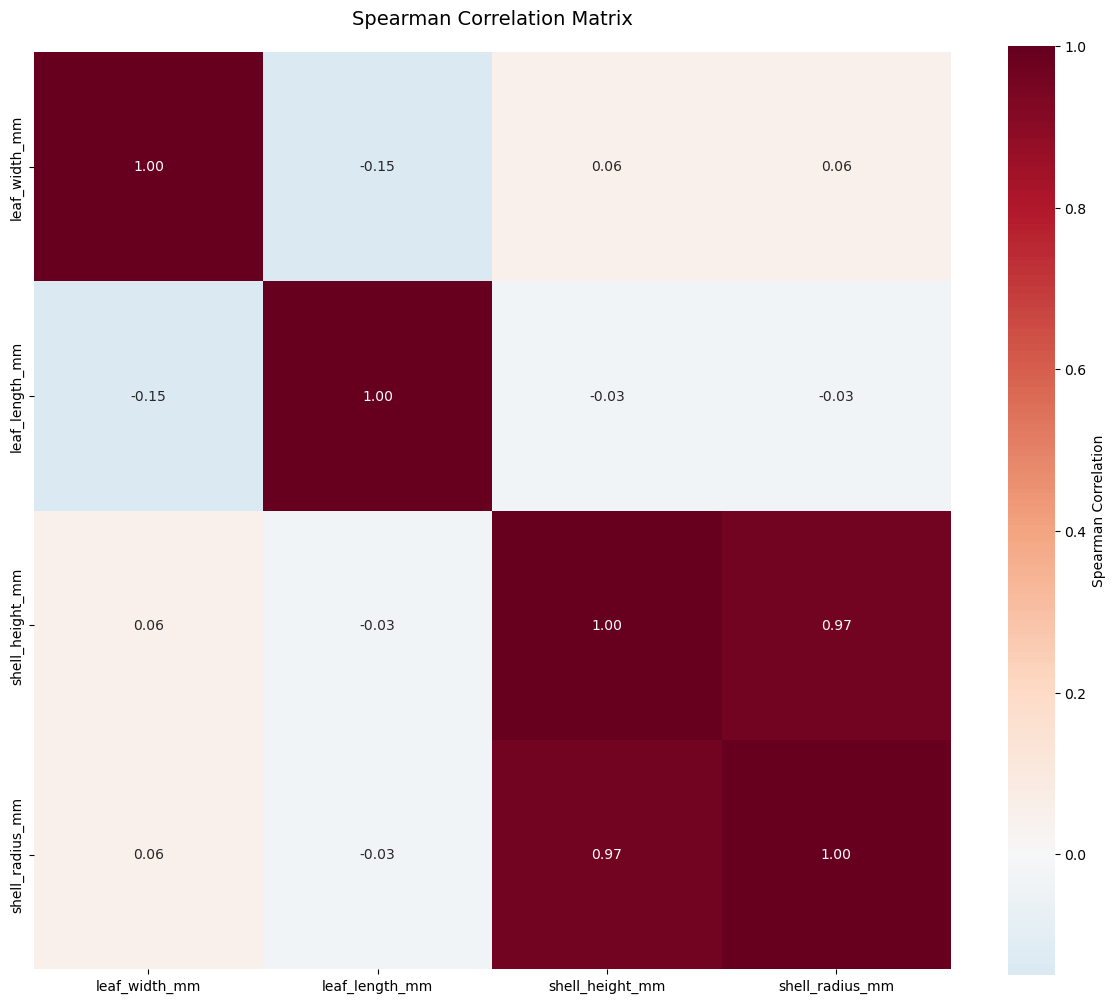

In [106]:
numeric_data = clean.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='RdBu_r',
            center=0,
            square=True,
            cbar_kws={'label': 'Spearman Correlation'})
plt.title('Spearman Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [107]:
assert isinstance(raw, pd.DataFrame)
assert isinstance(clean, pd.DataFrame)
assert clean.isna().sum().sum() == 0
assert len(raw.columns) == len(clean.columns)
assert TO_PREDICT in raw.columns
assert TO_PREDICT in clean.columns

In [108]:
transformed = clean.copy()
numeric_cols = transformed.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
sklearn_scaled = scaler.fit_transform(transformed[numeric_cols])

numpy_scaled = (transformed[numeric_cols] - transformed[numeric_cols].mean()) / transformed[numeric_cols].std()

difference = np.abs(sklearn_scaled - numpy_scaled.values).max()
print(f"\nScaling comparison:")
print(f"Maximum difference between sklearn and numpy scaling: {difference:.10f}")
print("Methods produce nearly identical results!" if difference < 1e-10 else f"Difference: {difference}")

transformed[numeric_cols] = sklearn_scaled


Scaling comparison:
Maximum difference between sklearn and numpy scaling: 0.0005511927
Difference: 0.00055119268701187


In [109]:
categorical_cols = transformed.select_dtypes(include=['object']).columns.tolist()

if TO_PREDICT in categorical_cols:
    categorical_cols.remove(TO_PREDICT)

transformed = pd.get_dummies(transformed, columns=categorical_cols, drop_first=True, dtype=int)

In [110]:
snail_classes = {genus: idx for idx, genus in enumerate(clean[TO_PREDICT].unique())}
print(f"\nSnail genus mapping: {snail_classes}")

transformed[TO_PREDICT] = transformed[TO_PREDICT].map(snail_classes)


Snail genus mapping: {'Spiralina': 0, 'Slimospira': 1, 'Mollisphora': 2, 'Flexorus': 3, 'Helixoda': 4, 'Caracolus': 5, 'Lunaspira': 6}


In [111]:
X = transformed.drop(columns=[TO_PREDICT])
y = transformed[TO_PREDICT]

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (2596, 10)
y shape: (2596,)


In [112]:
assert isinstance(transformed, pd.DataFrame)
assert transformed.isna().sum().sum() == 0
assert len(transformed.columns) > len(clean.columns)
assert TO_PREDICT in transformed.columns
assert transformed[TO_PREDICT].dtype == int
assert str not in transformed.dtypes  # CHECK IF WORKS
assert 2 in transformed[TO_PREDICT]
assert isinstance(X, pd.DataFrame)
assert len(X.columns) == len(transformed.columns) - 1
assert isinstance(y, pd.Series)
assert isinstance(snail_classes, dict)

In [113]:
def split_and_train_model(X, y, random_seed, model_func, max_iter=300):
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=random_seed
        )
        
        model = model_func(random_state=random_seed, max_iter=max_iter)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        
        return model
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None

print("\n" + "="*60)
print("Training Logistic Regression (baseline)")
print("="*60)

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X, y, test_size=0.20, random_state=42
)
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_base, y_train_base)
y_pred_base = baseline_model.predict(X_test_base)
baseline_accuracy = accuracy_score(y_test_base, y_pred_base)
print(f"Accuracy: {baseline_accuracy:.4f}")


Training Logistic Regression (baseline)
Accuracy: 0.7192


In [114]:
plant_feature_cols = ['leaf_length_mm', 'leaf_width_mm', 'leaf_surface_smooth', 'leaf_surface_waxy']
plants = transformed[plant_feature_cols].copy()

print(f"\nPlants data shape: {plants.shape}")


Plants data shape: (2596, 4)


In [115]:
cluster_setups = []

for damping in np.linspace(0.6, 0.9, 3):
    cluster_setups.append((
        'AffinityPropagation',
        AffinityPropagation,
        {'damping': damping, 'random_state': 42}
    ))

for n_clusters in range(3, 21, 4):  # 3, 7, 11, 15, 19
    cluster_setups.append((
        'SpectralClustering',
        SpectralClustering,
        {'n_clusters': n_clusters, 'random_state': 42}
    ))

for n_clusters in range(3, 21, 4):  # 3, 7, 11, 15, 19
    cluster_setups.append((
        'KMeans',
        KMeans,
        {'n_clusters': n_clusters, 'random_state': 42}
    ))

for eps in np.linspace(0.1, 0.5, 4):
    for min_samples in np.linspace(5, 40, 4, dtype=int):
        cluster_setups.append((
            'DBSCAN',
            DBSCAN,
            {'eps': eps, 'min_samples': int(min_samples)}
        ))

print(f"\nTotal clustering setups: {len(cluster_setups)}")


Total clustering setups: 29


In [116]:
obtained_clusters = {}

print("\nRunning clustering methods...")
for name, model_func, params in tqdm(cluster_setups):
    param_str = '_'.join([f"{k}={v:.3f}" if isinstance(v, float) else f"{k}={v}" 
                          for k, v in params.items()])
    description = f"{name}_{param_str}"
    
    model = model_func(**params)
    labels = model.fit_predict(plants)
    
    obtained_clusters[description] = labels.tolist()

print(f"\nObtained {len(obtained_clusters)} clustering results")


Running clustering methods...


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:42<00:00,  1.46s/it]


Obtained 29 clustering results


In [117]:
assert isinstance(plants, pd.DataFrame)
assert isinstance(cluster_setups, list)
assert isinstance(obtained_clusters, dict)
assert len(cluster_setups) == len(obtained_clusters)
assert len(cluster_setups) >= 26

In [118]:
results = {}

print("\n" + "="*60)
print("Testing clustering features with Logistic Regression")
print("="*60)

for cluster_name, cluster_labels in tqdm(obtained_clusters.items(), desc="Testing features"):
    XX = X.copy()
    XX['plant_cluster'] = cluster_labels
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            XX, y, test_size=0.20, random_state=42
        )
        
        model = LogisticRegression(random_state=42, max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results[cluster_name] = accuracy
        
    except Exception as e:
        results[cluster_name] = 0.0


Testing clustering features with Logistic Regression


Testing features: 100%|████████████████████████████████████████████████████████████████| 29/29 [00:15<00:00,  1.90it/s]


In [119]:
best_feature = max(results, key=results.get)
best_accuracy = results[best_feature]

print("\n" + "="*60)
print("BEST RESULT")
print("="*60)
print(f"Best clustering feature: {best_feature}")
print(f"Accuracy achieved: {best_accuracy:.4f}")
print(f"Improvement over baseline: {best_accuracy - baseline_accuracy:.4f}")


BEST RESULT
Best clustering feature: DBSCAN_eps=0.233_min_samples=28
Accuracy achieved: 0.8135
Improvement over baseline: 0.0942
